# Train a regression ConvNN model using BOHB tuner

In [1]:
import sys  
sys.path.insert(0, '../../codes/')

from predict_observational_dataset_v2 import ProcessObservationalDataset
from train_regression import *
from bohb_optimizer_2 import *


2023-06-16 13:31:51.405850: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading BokehJS ...

Loading BokehJS ...

Loading BokehJS ...

In [2]:
# Libraries for BOHB Package 
import logging
logging.basicConfig(level=logging.WARNING)

import argparse

import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres

from hpbandster.optimizers import BOHB as BOHB
from hpbandster.examples.commons import MyWorker

from tensorflow.keras.models import load_model
import ConfigSpace as CS
from hpbandster.core.worker import Worker

# Step 1: Load the dataset

In [3]:
# original dataset
df=pd.read_csv('../../datasets/browndwarf_R100_v4_newWL_v2.csv.bz2', compression='bz2')
df.head(3)

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
0,5.0,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
1,5.0,1100,0.25,-0.7,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
2,5.0,1100,0.25,-0.5,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no


In [5]:
wl = pd.read_csv('../../datasets/wl.csv')
wl.head(3)

,wl
0,2.511960
1,2.486966
2,2.462220


In [6]:
df.iloc[::10]

,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
0,5.00,1100,0.25,-1.0,9.103045e-08,1.181658e-07,1.307868e-07,1.269229e-07,1.159179e-07,8.925110e-08,...,9.640859e-08,7.612550e-08,6.901364e-08,6.247359e-08,4.112384e-08,5.127995e-08,4.897355e-08,4.087795e-08,2.791689e-08,no
10,5.00,1100,0.25,1.7,8.540979e-09,9.610928e-09,8.362026e-09,6.331807e-09,5.411898e-09,3.597492e-09,...,2.589948e-09,1.400508e-09,1.423739e-09,1.331622e-09,5.718932e-10,2.525684e-09,2.577776e-09,2.171606e-09,1.170498e-09,no
20,5.00,1100,0.50,1.0,2.089233e-08,2.547443e-08,2.398659e-08,1.954245e-08,1.673706e-08,1.128757e-08,...,1.030422e-08,6.744711e-09,6.570654e-09,5.994584e-09,3.266539e-09,6.722988e-09,6.756289e-09,5.708415e-09,3.422240e-09,no
30,5.00,1100,1.00,0.5,3.773544e-08,4.306029e-08,3.789344e-08,2.982717e-08,2.555826e-08,1.704151e-08,...,3.370933e-08,2.475817e-08,2.292027e-08,2.084380e-08,1.293259e-08,1.818421e-08,1.723477e-08,1.401317e-08,8.880054e-09,no
40,5.00,1100,1.50,0.0,7.403044e-08,8.240733e-08,7.323895e-08,5.885655e-08,5.086389e-08,3.452053e-08,...,1.067845e-07,8.506743e-08,7.629151e-08,6.833675e-08,4.665959e-08,5.297000e-08,4.829532e-08,3.887601e-08,2.587082e-08,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30840,3.25,1000,1.00,-1.0,6.179704e-08,6.023661e-08,4.317990e-08,3.128656e-08,2.771920e-08,1.748527e-08,...,6.074206e-08,4.763676e-08,4.974581e-08,4.320090e-08,2.942153e-08,4.588604e-08,4.660016e-08,3.899730e-08,2.401752e-08,no
30850,3.25,1000,1.00,1.7,4.587650e-09,3.838308e-09,2.586146e-09,1.860407e-09,1.635306e-09,1.152218e-09,...,1.364340e-09,8.768095e-10,8.903187e-10,7.791423e-10,4.586279e-10,1.281345e-09,9.366753e-10,5.737637e-10,3.020979e-10,no
30860,3.25,1000,1.50,1.0,9.151923e-09,7.599074e-09,4.870096e-09,3.395405e-09,2.993091e-09,2.001870e-09,...,8.316857e-09,5.922216e-09,5.734787e-09,5.036230e-09,3.292385e-09,4.859911e-09,3.820969e-09,2.376922e-09,1.196810e-09,no
30870,3.25,1000,2.00,0.5,1.755109e-08,1.456820e-08,9.125922e-09,6.253583e-09,5.540055e-09,3.570220e-09,...,3.041929e-08,2.417082e-08,2.437794e-08,2.183006e-08,1.552078e-08,1.638151e-08,1.205167e-08,7.349473e-09,3.697040e-09,no


## Prepare feature variables (X) and targets (y)

In [7]:
df = df[df['is_augmented'].isin(['no'])]
X = df.drop(
    columns=['gravity', 
             'temperature', 
             'c_o_ratio', 
             'metallicity', 
             'is_augmented'])#.astype(np.float32)

y = df[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]]#.astype(np.float32)


In [8]:
y['temperature'] = np.log10(y['temperature'])

skewness:


{('c_o_ratio', 0.1577441958491052),
 ('gravity', 0.0),
 ('metallicity', 0.16546438330218305),
 ('temperature', -0.04214190742902561)}

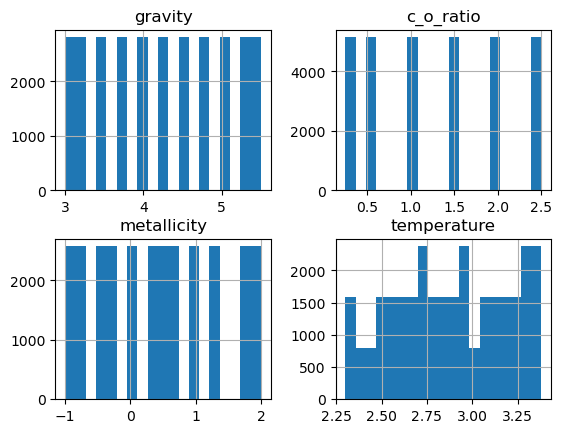

In [9]:
print( 'skewness:' )
display(set( zip(['gravity', 'c_o_ratio', 'metallicity', 'temperature'],(stats.skew(y[['gravity', 'c_o_ratio', 'metallicity', 'temperature', ]])))))
y.hist(grid=True, bins=19);

In [10]:
y.head()

,gravity,c_o_ratio,metallicity,temperature
0,5.0,0.25,-1.0,3.041393
1,5.0,0.25,-0.7,3.041393
2,5.0,0.25,-0.5,3.041393
3,5.0,0.25,-0.3,3.041393
4,5.0,0.25,0.0,3.041393


---

# Step 2: Data Processing

In [11]:
# Create an instance of TrainCNNRegression
train_cnn_regression = TrainRegression(feature_values=X,
                             feature_names=X.columns,
                             target_values=y.to_numpy(),
                             target_name=['gravity', 'c_o_ratio', 'metallicity', 'temperature'],
                             is_tuned='yes',
                             param_grid=None,
                             spectral_resolution=100,
                             is_feature_improved='no',
                             n_jobs=4,
                             cv=5,
                             is_augmented='no',
                             ml_model=None,
                             ml_model_str='CNN')

In [12]:
# Split the dataset into train and test sets
train_cnn_regression.split_train_validation_test(test_size=0.1, val_size=0.1)

In [13]:
# normalize the X features using MinMax Scaler
train_cnn_regression.normalize_X_row_wise()

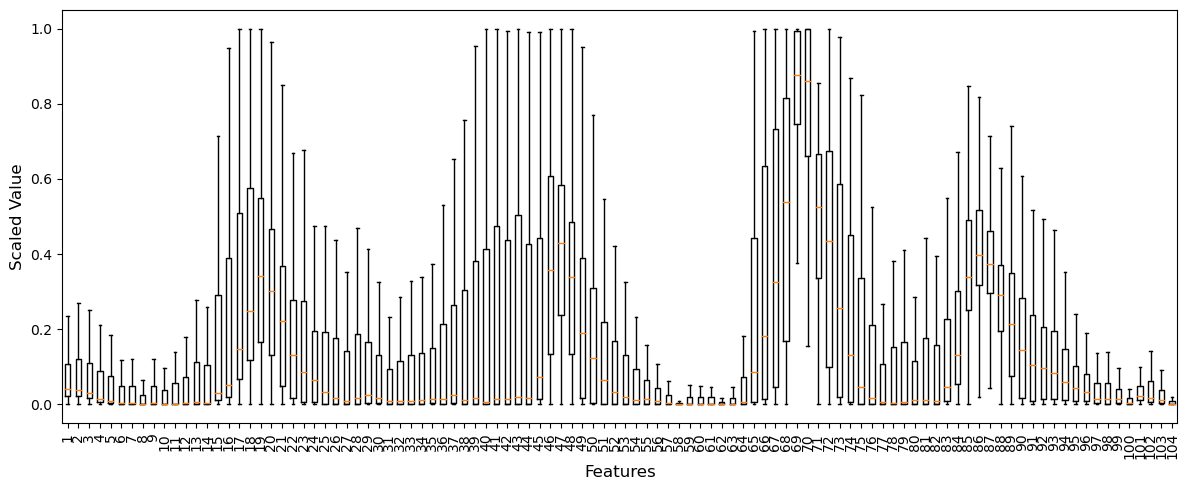

In [14]:
train_cnn_regression.plot_boxplot_scaled_features(train_cnn_regression.X_train_normalized_rowwise)

In [15]:
# Standardize the y features using Standard Scaler
train_cnn_regression.standardize_y_column_wise()

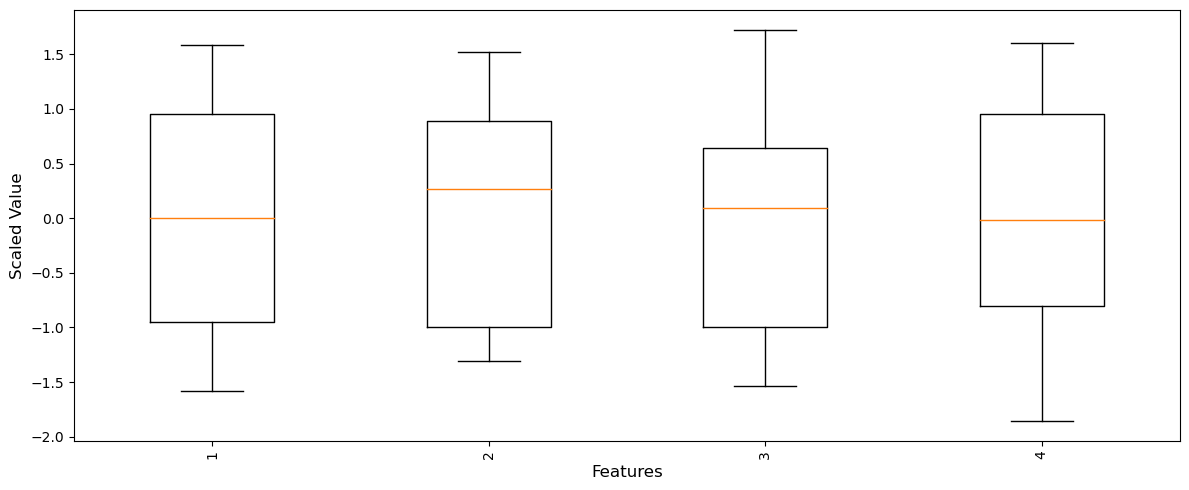

In [16]:
train_cnn_regression.plot_boxplot_scaled_features(train_cnn_regression.y_train_standardized_columnwise)

In [17]:
# train_cnn_regression.y_train_standardized_columnwise

In [18]:
train_cnn_regression.X_train_min = train_cnn_regression.X_train.min(axis=1)
train_cnn_regression.X_train_max = train_cnn_regression.X_train.max(axis=1)

In [19]:
train_cnn_regression.X_val_min = train_cnn_regression.X_val.min(axis=1)
train_cnn_regression.X_val_max = train_cnn_regression.X_val.max(axis=1)

In [20]:
train_cnn_regression.X_test_min = train_cnn_regression.X_test.min(axis=1)
train_cnn_regression.X_test_max = train_cnn_regression.X_test.max(axis=1)

In [21]:
df_MinMax_train = pd.DataFrame((train_cnn_regression.X_train_min, train_cnn_regression.X_train_max)).T
df_MinMax_val = pd.DataFrame((train_cnn_regression.X_val_min, train_cnn_regression.X_val_max)).T
df_MinMax_test = pd.DataFrame((train_cnn_regression.X_test_min, train_cnn_regression.X_test_max)).T

In [22]:
df_MinMax_train.rename(columns={0:'min', 1:'max'}, inplace=True)

In [23]:
df_MinMax_train

,min,max
28744,8.265340e-12,3.445259e-08
6288,8.080712e-22,8.397132e-14
13749,2.734403e-07,8.632182e-06
11713,4.414951e-16,3.373262e-10
15538,3.722576e-07,6.859888e-06
...,...,...
1806,3.537783e-10,2.404020e-07
10765,9.266921e-07,8.640541e-06
16472,3.583572e-12,1.047753e-07
27891,3.782887e-13,8.244911e-09


In [24]:
# plt.loglog(train_cnn_regression.X_train_max, 'k.', alpha = 0.4)
# plt.loglog(train_cnn_regression.X_train, 'r.', label='X_train', alpha = 0.4)
# plt.loglog(train_cnn_regression.X_train_min, 'r.', alpha = 0.4)

---

In [25]:
train_cnn_regression.standardize_X_column_wise(
                                                            X_train = df_MinMax_train.values,
                                                            X_val   = df_MinMax_val.values,
                                                            X_test  = df_MinMax_test.values,
                                                        )

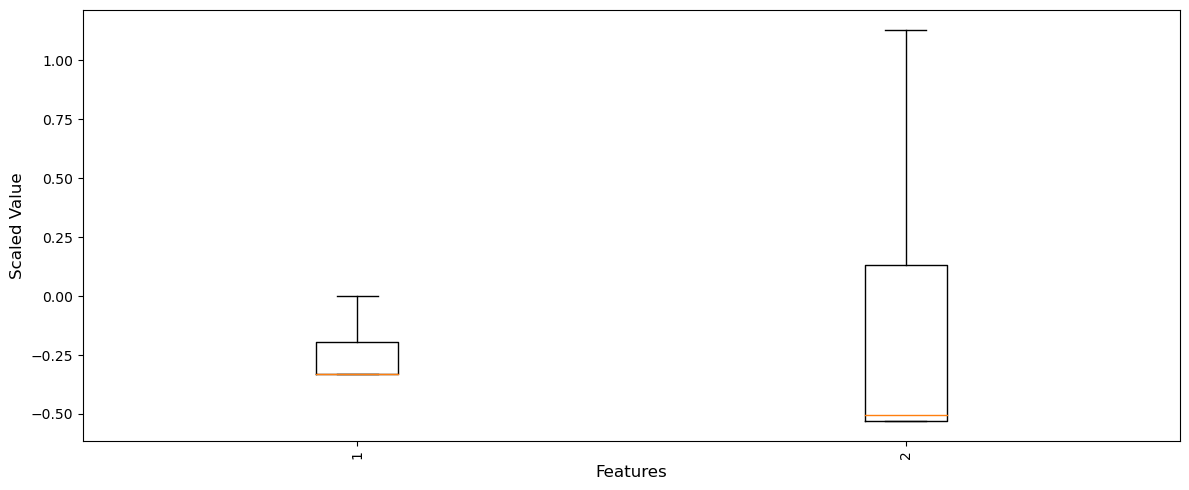

In [26]:
train_cnn_regression.plot_boxplot_scaled_features(train_cnn_regression.X_test_standardized_columnwise)

# Step 3: Train CNN model

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Define the model architecture
input_1 = tf.keras.layers.Input(shape=(104, 1))
input_2 = tf.keras.layers.Input(shape=(2,))

model  = Conv1D(64*2, 3, 
                 kernel_initializer = 'he_normal', 
                 activation='relu', 
                 input_shape=(104, 1))(input_1)

model  = Conv1D(64*4, 3, 
                kernel_initializer = 'he_normal', 
                activation='relu')(model)

model  = Conv1D(128*8, 3, 
                kernel_initializer = 'he_normal', 
                activation='relu')(model)

model  = MaxPooling1D(2)(model)

model  = Conv1D(128*8, 3, 
                kernel_initializer = 'he_normal', 
                activation='relu')(model)

model  = Conv1D(128*16, 3, 
                kernel_initializer = 'he_normal', 
                activation='relu')(model)


model  = MaxPooling1D(2)(model)
model  = Flatten()(model)

model = tf.keras.layers.concatenate([model, input_2], 
                                                   name='Concatenated_Layer')


model  = Dense(128,                      
                kernel_initializer = 'he_normal',
                activation='relu')(model)

model  = Dense(128*4,                      
                kernel_initializer = 'he_normal',
                activation='relu')(model)

out__gravity =  Dense(1, 
                      activation='linear',
                name='gravity')(model)  # No activation function for regression

out__c_o_ratio = Dense(1, 
                      activation='linear',
                      name='c_o_ratio')(model)  # No activation function for regression

out__metallicity = Dense(1, 
                        activation='linear',
                        name='metallicity')(model)  # No activation function for regression

out__temperature = Dense(1, 
                        activation='linear',
                        name='temperature')(model)  # No activation function for regression

model = tf.keras.Model(inputs=[input_1, input_2], 
                               outputs=[out__gravity, out__c_o_ratio, out__metallicity, out__temperature])


# Compile the model with an optimizer, loss function, and metrics
model.compile(loss='huber_loss', 
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),  
              metrics=['mae'])

# Train the model
history = model.fit(x = [train_cnn_regression.X_train_normalized_rowwise, 
                         train_cnn_regression.X_train_standardized_columnwise], 
          y = [train_cnn_regression.y_train_standardized_columnwise[:,0], 
               train_cnn_regression.y_train_standardized_columnwise[:,1],
               train_cnn_regression.y_train_standardized_columnwise[:,2],
               train_cnn_regression.y_train_standardized_columnwise[:,3]], 
          batch_size = 32, 
          epochs = 30, 
          validation_data=([train_cnn_regression.X_val_normalized_rowwise, 
                            train_cnn_regression.X_val_standardized_columnwise], 
                          [train_cnn_regression.y_val_standardized_columnwise[:,0], 
                           train_cnn_regression.y_val_standardized_columnwise[:,1],
                           train_cnn_regression.y_val_standardized_columnwise[:,2],
                           train_cnn_regression.y_val_standardized_columnwise[:,3]]))



2023-06-15 12:48:19.122762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-15 12:48:19.128885: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Epoch 1/30
782/782 [==============================] - 540s 687ms/step - loss: 0.3313 - gravity_loss: 0.1276 - c_o_ratio_loss: 0.0726 - metallicity_loss: 0.1122 - temperature_loss: 0.0189 - gravity_mae: 0.3764 - c_o_ratio_mae: 0.2832 - metallicity_mae: 0.3696 - temperature_mae: 0.1189 - val_loss: 0.1555 - val_gravity_loss: 0.0395 - val_c_o_ratio_loss: 0.0396 - val_metallicity_loss: 0.0725 - val_temperature_loss: 0.0039 - val_gravity_mae: 0.2069 - val_c_o_ratio_mae: 0.2068 - val_metallicity_mae: 0.2984 - val_temperature_mae: 0.0657
Epoch 2/30
782/782 [==============================] - 585s 748ms/step - loss: 0.1291 - gravity_loss: 0.0338 - c_o_ratio_loss: 0.0289 - metallicity_loss: 0.0631 - temperature_loss: 0.0033 - gravity_mae: 0.1857 - c_o_ratio_mae: 0.1755 - metallicity_mae: 0.2778 - temperature_mae: 0.0628 - val_loss: 0.1059 - val_gravity_loss: 0.0223 - val_c_o_ratio_loss: 0.0228 - val_metallicity_loss: 0.0561 - val_temperature_loss: 0.0046 - val_gravity_mae: 0.1512 - val_c_o_ratio_

In [29]:
train_cnn_regression.trained_model = model

# Save Trained Model

In [264]:
train_cnn_regression.trained_model.save('../../outputs/regression/trained_models/my_model_architecture__xNorm_yStand_MinMax_v21.h5')
train_cnn_regression.trained_model.save_weights('../../outputs/regression/trained_models/my_model_weights__xNorm_yStand_MinMax_v21.h5')

with open('../../outputs/regression/trained_models/training_history__xNorm_yStand_MinMax_v21.pkl', 'wb') as file:
    pk.dump(history, file)
    


# Load Saved Models

In [27]:
model = load_model('../../outputs/regression/trained_models/my_model_architecture__xNorm_yStand_MinMax.h5')
model.load_weights('../../outputs/regression/trained_models/my_model_weights__xNorm_yStand_MinMax.h5')

# Loading the saved history object
with open('../../outputs/regression/trained_models/training_history__xNorm_yStand_MinMax.pkl', 'rb') as file:
    history = pk.load(file)    

2023-06-16 13:33:02.126328: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 13:33:02.302273: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [28]:
train_cnn_regression.trained_model = model
train_cnn_regression.trained_model_history = history

# Step 3: Check Trained Model

---

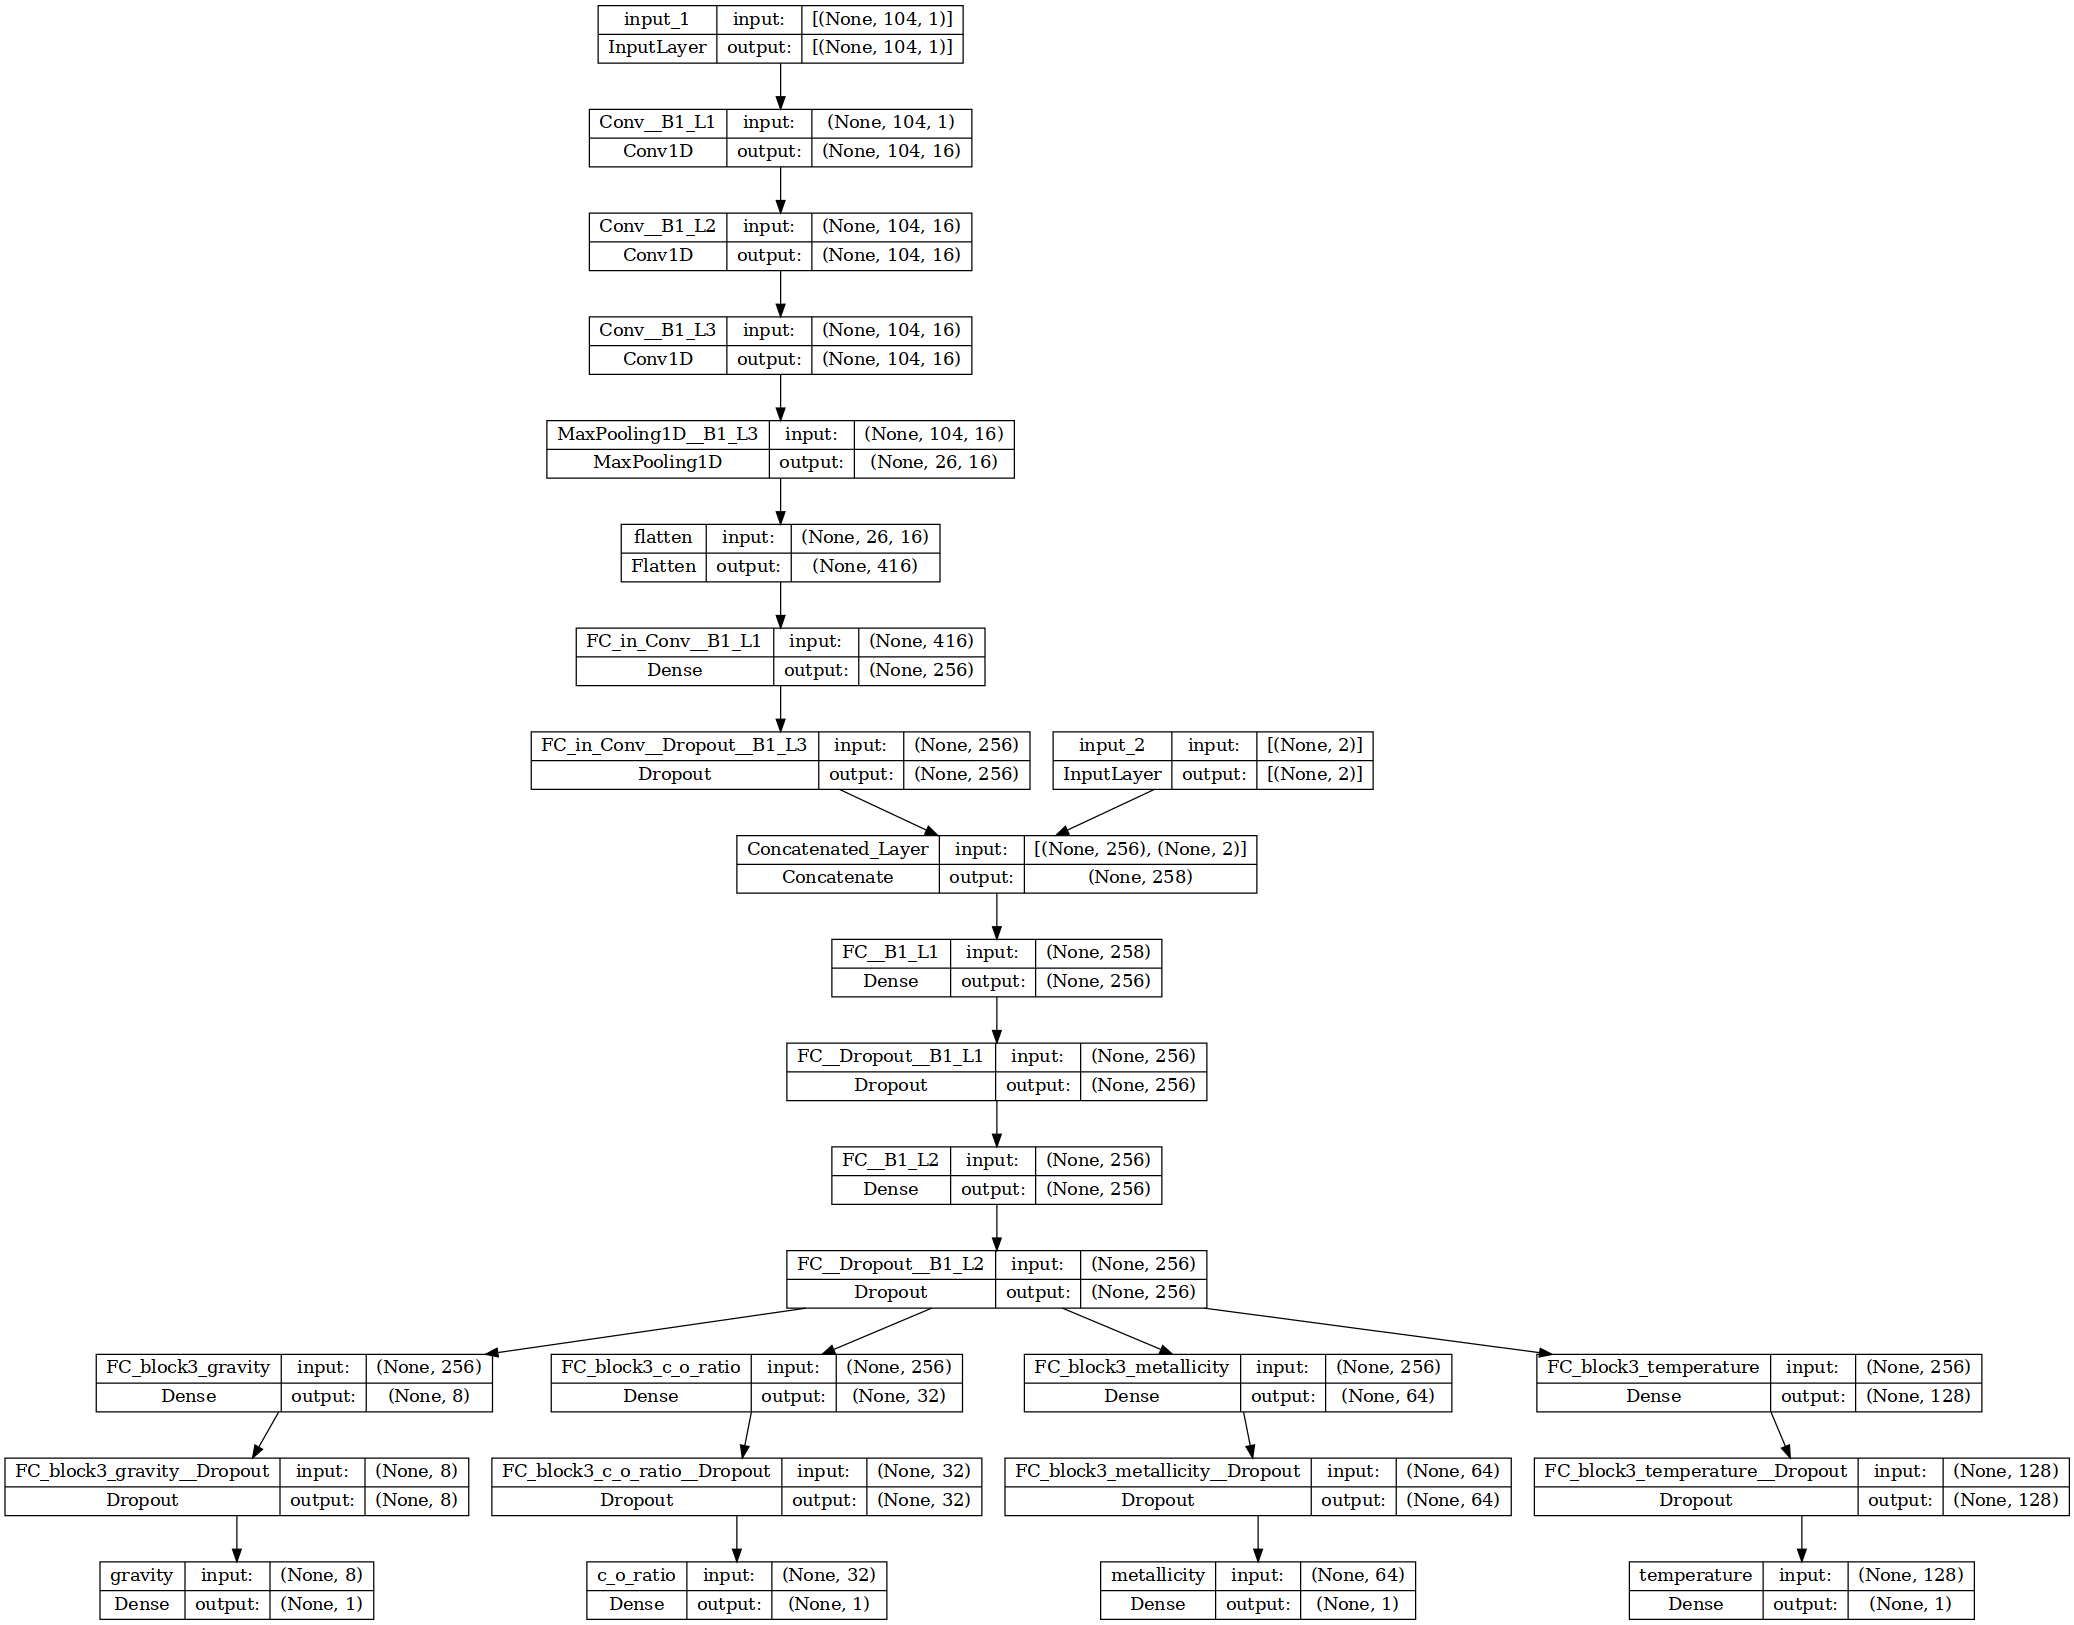

In [29]:
tf.keras.utils.plot_model(
                train_cnn_regression.trained_model,
                to_file="model.png",
                show_shapes=True,
                show_dtype=False,
                show_layer_names=True,
                rankdir="TB",
                expand_nested=True,
                dpi=90,
                layer_range=None,
                show_layer_activations=False,
)

In [30]:
train_cnn_regression.trained_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 104, 1)]     0           []                               
                                                                                                  
 Conv__B1_L1 (Conv1D)           (None, 104, 16)      128         ['input_1[0][0]']                
                                                                                                  
 Conv__B1_L2 (Conv1D)           (None, 104, 16)      1808        ['Conv__B1_L1[0][0]']            
                                                                                                  
 Conv__B1_L3 (Conv1D)           (None, 104, 16)      1808        ['Conv__B1_L2[0][0]']            
                                                                                              

In [31]:
train_cnn_regression.plot_model_loss(title = 'X:NormRow, y:StandCol - MinMax:StandCol, ToyCNNmodel')

### Print outputs

In [271]:
# import pprint 
# pp = pprint.PrettyPrinter(indent=4)
# pp.pprint(trained_cnn_model)

### Plot the trained CNN model archeticture 

### Plot Y predicted vs Y_Actual

In [32]:
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, explained_variance_score

from scipy import stats
import seaborn as sns

def regression_report(trained_model, 
                      Xtrain, 
                      Xtest, 
                      ytrain, 
                      ytest,
                      target_i,
                          xy_top = [0.55, 0.85],
                          xy_bottom = [0.05, 0.8],
                          print_results = True):
    
    y_pred_train = np.array(trained_model.trained_model.predict(Xtrain) )[:,:,0].T
    y_pred_train_list = trained_model.standardize_y_ColumnWise.inverse_transform( y_pred_train )
    y_pred_train_list [:,3] = 10**y_pred_train_list[:,3]

    y_act_train_list = trained_model.standardize_y_ColumnWise.inverse_transform( ytrain )
    y_act_train_list [:,3] = 10**y_act_train_list[:,3]

    y_pred_test = np.array(trained_model.trained_model.predict(Xtest))[:,:,0].T
    y_pred_test_list = trained_model.standardize_y_ColumnWise.inverse_transform(y_pred_test)
    y_pred_test_list[:,3] = 10**y_pred_test_list[:,3]

    y_act_test_list = trained_model.standardize_y_ColumnWise.inverse_transform(ytest)
    y_act_test_list[:,3] = 10**y_act_test_list[:,3]

    
    
    for i in range(0,target_i):
        y_pred_train = y_pred_train_list[:,i]
        y_act_train = y_act_train_list[:,i]
            
        y_pred_test = y_pred_test_list[:,i]
        y_act_test = y_act_test_list[:,i]

            
        
        residual_train_list = y_pred_train - y_act_train
        residual_test_list = y_pred_test - y_act_test


        f, axs = plt.subplots(2,1,
                            figsize=(5,5),
                            sharey=False,
                            sharex=False,
                            gridspec_kw=dict(height_ratios=[1,3])
                            )

        r2_score_train = r2_score(y_pred_train , y_act_train)
        r2_score_test = r2_score(y_pred_test , y_act_test)

        rmse_score_train = np.sqrt( mean_squared_error(y_pred_train , y_act_train) )
        rmse_score_test = np.sqrt( mean_squared_error(y_pred_test , y_act_test) )

    #     print(mean_squared_error(y_pred_train[:,target_i] , ytrain[:,target_i]))

        mean_test = np.round(np.mean(residual_test_list),2)
        std_test = np.round(np.std(residual_test_list),2)
        mean_train = np.round(np.mean(residual_train_list),2)
        std_train = np.round(np.std(residual_train_list),2)



        skew_test = stats.skew(residual_test_list)
        skew_train = stats.skew(residual_train_list)

        if print:
            print('\n\n----------------------- Test ------------------------')
            print('R2: {:2.2f} \t  RMSE: {:2.2f} \t Mean+/-STD: {:2.2f}+/-{:2.2f}'.format(r2_score_test, rmse_score_train, mean_test, std_test))

            print('\n----------------------- Train ------------------------')
            print('R2: {:2.2f} \t  RMSE: {:2.2f} \t Mean+/-STD: {:2.2f}+/-{:2.2f}'.format(r2_score_train, rmse_score_test, mean_train, std_train))
            # print(' r2_score, rmse_score_test')
            # print(r2_score_train, rmse_score_train)
            # print('------ mean, std -----------')
            # print( mean_train, std_train)
            # print('------- Skewness -----------')
            # print(skew_train)
            # print('------------------\n\n\n')

        axs[0].set_title(['Gravity','C_O_ratio', 'Metallicity', 'Temperature'][i],fontsize = 14)

        sns.histplot(data= residual_train_list, 
                    ax=axs[0],
                    label='train', 
                    alpha = 0.7, bins=19, log_scale=False, stat='percent', legend=True, linewidth=0
                    )

        sns.histplot(data= residual_test_list, 
                    label='test', 
                    ax=axs[0],
                    alpha = 0.3, bins=19, stat='percent', legend=True,linewidth=0
                )

        axs[0].set_xlim((-(abs(mean_train)+3*std_train),(abs(mean_train)+3*std_train)))
        axs[0].set_ylim((1e-1,100))
        axs[0].set_yscale('log')
        axs[0].set_ylabel('Probability %', fontsize = 12)

        # yact = cnn_model.StandardScaler_column_y.inverse_transform(  np.array(ytrain))[:,target_i]
        # ypred = cnn_model.StandardScaler_column_y.inverse_transform(  np.array(cnn_model.trained_model.predict(Xtrain))[:,:,0].T )[:,target_i]
        sns.scatterplot(
                    y = y_pred_train,
                    x = y_act_train,
                    label='train', 
                    ax=axs[1],
                    alpha = 0.7, 
                    legend=False,
                    )

        # yact = cnn_model.StandardScaler_column_y.inverse_transform(  np.array(ytest))[:,target_i]
        # ypred = cnn_model.StandardScaler_column_y.inverse_transform(  np.array(cnn_model.trained_model.predict(Xtest))[:,:,0].T )[:,target_i]
        sns.scatterplot(
                    y = y_pred_test,
                    x = y_act_test,
                    label = 'test', 
                    ax = axs[1],
                    alpha = 0.7, legend=False,
                    )
        # axs[1].set_xlim((min(y_pred_train),max(y_pred_train)))



        axs[1].set_ylabel('Predicted value', fontsize = 12)
        axs[1].set_xlabel('Actual value', fontsize = 12)


        axs[0].annotate(r'$\tilde{\mu}_{{\rm 3, train}}$= '+f'{np.round(skew_train,2)}', 
                            fontsize=11, xy=(xy_top[0],xy_top[1]+0.08), xycoords='axes fraction')
        axs[0].annotate(r'$\tilde{\mu}_{{\rm 3, test}}$ = '+f'{np.round(skew_test,2)}', 
                            fontsize=11, xy=(xy_top[0],xy_top[1]-0.08), xycoords='axes fraction')

        axs[1].annotate(r'R$^2_{\rm train}$='+f'{"%0.2f"%r2_score_train} [{"%0.2f"%abs(mean_train)}$\pm${"%0.2f"%std_train}]', 
                            fontsize=11, xy=(xy_bottom[0],xy_bottom[1]+0.06), xycoords='axes fraction')
        axs[1].annotate(r'R$^2_{\rm test}$ ='+f'{np.round(r2_score_test,2)} [{"%0.2f"%mean_test}$\pm${"%0.2f"%std_test}]',
                            fontsize=11, xy=(xy_bottom[0],xy_bottom[1]-0.06), xycoords='axes fraction')





        axs[1].legend(loc='lower right', fontsize = 11)
        # plt.yscale('log')

        f.tight_layout()
        plt.show()

In [33]:
i = 1
regression_report(
        trained_model = train_cnn_regression,
    
        Xtrain = [train_cnn_regression.X_train_normalized_rowwise[::i],
                  train_cnn_regression.X_train_standardized_columnwise[::i]],
    
        Xtest  = [train_cnn_regression.X_test_normalized_rowwise[::i], 
                  train_cnn_regression.X_test_standardized_columnwise[::i]],
    
        ytrain = train_cnn_regression.y_train_standardized_columnwise[::i],
    
        ytest  = train_cnn_regression.y_test_standardized_columnwise[::i],
    
        target_i = 4,
        
        xy_top   = [0.05, 0.7],
        xy_bottom= [0.05, 0.85],
        print_results = False,        
                 )

281/782 [=========>....................] - ETA: 2:19


KeyboardInterrupt



---X_test_normalized_rowwise

# Step 4: Predict Observational data using the trained model

## ROSS 458C

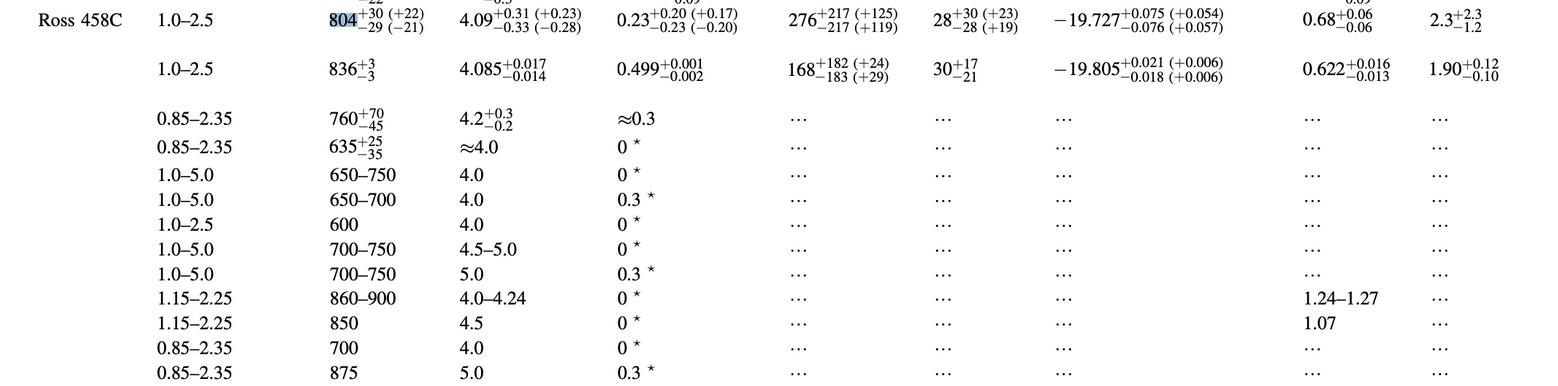

In [34]:
import pandas as pd
import numpy as np
nearest_value_list = []

def filter_dataframe(data, targets):
    # Check if the values exist in the respective columns
    for col, value in targets.items():
        if value not in data[col].values:
            # Find the nearest values in the column
            nearest_value = data[col].values[np.argmin(np.abs(df[col].values - value))]
            print(nearest_value)
            targets[col] = nearest_value
            nearest_value_list.append(nearest_value)

    # Filter the DataFrame based on the values
    filtered_df = data
    for col, value in targets.items():
        filtered_df = filtered_df[filtered_df[col] == value]

    return nearest_value_list, filtered_df

# Print the filtered DataFrame

# Filter the DataFrame and get the result
# nearest_value1, filtered_df1 = filter_dataframe(df, targets)
# display(filtered_df1)


#### ====================================================================================================
#### ====================================================================================================
#### ====================================================================================================
#### ====================================================================================================
#### ====================================================================================================

# Specify target values
# Create the figure


def plot_predicted_vs_observed(data = df, 
                               targets = targets,
                               object_name = 'GJ570D',):
    
    nearest_value1, filtered_df1 = filter_dataframe(data, targets)

    p = figure(title=f'{object_name} [XNorm, yStand] Predicted: '+', '.join([['logg= ','C/O= ', 'Met= ', 'T= '][i]+str(np.round(y_pred[0][i],2)) for i in  range(4)]), 
               x_axis_label='features [wavelengths]', 
               y_axis_label='Flux (Fν)',
               width=1000, height=300,
               y_axis_type = 'log')

    # Add the scatter plot
    filtered_df1 = filtered_df1.drop(columns=['gravity', 'c_o_ratio', 'metallicity', 'temperature','is_augmented']).to_numpy()[0]

    p.line(x =wl['wl'] , y=filtered_df1, 
           line_width = 1,
           legend_label='Modeled:'+', '.join([['logg= ','C/O= ', 'Met= ', 'T= '][i]+str(np.round(nearest_value1[i],2)) for i in  range(4)]))
    p.circle(x = wl['wl'] , y=filtered_df1.iloc[:,4:-1].values[0],
           line_width = 2,
           # legend_label='Observation'
            )



    p.line(x =wl['wl'] , y=bd_object.df_flux_object.iloc[:, ::-1].values[0],
           line_color = 'orange', line_width = 2,
           legend_label='Observation')

    # Increase size of x and y ticks
    p.title.text_font_size = '12pt'
    p.xaxis.major_label_text_font_size = '12pt'
    p.xaxis.axis_label_text_font_size = '12pt'
    p.yaxis.major_label_text_font_size = '12pt'
    p.yaxis.axis_label_text_font_size = '12pt'


    p.legend.location = "bottom_right"
    p.legend.background_fill_color = 'white'
    p.legend.background_fill_alpha = 0.5

            # Add the error bars using vbar
    # p.vbar('x_err', top='upper', bottom='lower', width=0.001, source=source, line_color='grey')

    # Show the plot
    show(p)

NameError: name 'targets' is not defined

In [35]:
import pandas as pd
import numpy as np

def filter_dataframe(df, targets):
    # Check if the values exist in the respective columns
    for col, value in targets.items():
        if value not in df[col].values:
            # Find the nearest values in the column
            nearest_value = df[col].values[np.argmin(np.abs(df[col].values - value))]
            print(nearest_value)
            targets[col] = nearest_value

    # Filter the DataFrame based on the values
    filtered_df = df
    for col, value in targets.items():
        filtered_df = filtered_df[filtered_df[col] == value]

    return filtered_df

# # Specify target values
# targets = dict ( zip( ['gravity', 'c_o_ratio', 'metallicity', 'temperature'] , [y_pred[0][i] for i in range(4)]) )
# # Print the filtered DataFrame

# # Filter the DataFrame and get the result
# filtered_df1 = filter_dataframe(df, targets)
# display(filtered_df1)

In [36]:
fluxcal.head()

NameError: name 'fluxcal' is not defined

In [37]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook

def plot_spectra_errorbar(object_name, x, y, error):
    # # Sample data
    # x = fluxcal['wl']
    # y = fluxcal['F_lambda']
    # error = fluxcal['F_lambda_error']

    # Calculate the error bar coordinates
    x_err = x
    y_err = y
    upper = [y_val + err_val for y_val, err_val in zip(y, error)]
    lower = [y_val - err_val for y_val, err_val in zip(y, error)]

    # Create a ColumnDataSource to store the data
    source = ColumnDataSource(data=dict(x=x, y=y, x_err=x_err, y_err=y_err, upper=upper, lower=lower))

    # Create the figure
    p = figure(title=object_name+': Calibrated Observational Spectra', 
               x_axis_label='features [wavelengths]', 
               y_axis_label='Flux (Fν)',
               width=1000, height=300,
               y_axis_type='log')

    # Set the font size for axis labels and tick labels
    p.xaxis.axis_label_text_font_size = '14pt'
    p.yaxis.axis_label_text_font_size = '14pt'
    p.xaxis.major_label_text_font_size = '12pt'
    p.yaxis.major_label_text_font_size = '12pt'

    # Add the scatter plot
    p.scatter('x', 'y', source=source, legend_label='Data')

    # Add the error bars using vbar
    p.vbar('x_err', top='upper', bottom='lower', width=0.001, source=source, line_color='gray', line_alpha = 0.4)

    # Show the plot
    output_notebook()
    show(p)


In [38]:
import seaborn as sns
def boxplot_hist(data, x_label, xy_loc):
    
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    sns.histplot(data, ax=ax_hist, kde=True, stat='probability')
    sns.boxplot(x = data, ax=ax_box, showmeans=True, meanline = True,
                meanprops={"marker": "|",
                           "markeredgecolor": "white",
                           "markersize": "30", 
                            }
                       )
    
    fig.set_figheight(3)
    fig.set_figwidth(3)

    ax_box.set(xlabel='')
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    ax_box.set_yticks([])

    mean = np.round(np.mean(data),2)
    std = np.round(np.std(data),2)
    plt.annotate(f'{x_label}='+str(np.round(mean,2))+'$\pm$'+str(np.round(std,2)), fontsize=11, 
                 xy=(xy_loc[0], xy_loc[1]), xycoords='axes fraction')
                    
    plt.xlabel(x_label, fontsize = 12)

    plt.show()

In [39]:
import random
from bokeh.palettes import Magma, Inferno, Plasma, Viridis, Cividis
from bokeh.palettes import  viridis, inferno
       

    
def PredictObsParametersRegression2(object_name, 
                                    predict_from_random_spectra = True,
                                    random_spectra_num=10,
                                    print_results = False,
                                    plot_randomly_generated_spectra = False,
                                    print_df_describe = False,
                                    plot_histogram = False,
                                    plot_observational_spectra_errorbar = True,
                                    plot_boxplot_hist = True,
                                    plot_predicted_vs_observed_ = True,
                                   ):


    spectra_list = []
    param_list = []    
    color = viridis(101).__iter__()


    fluxcal = pd.read_csv(f'../../datasets/observational_spectra/{object_name}_fluxcal.dat', 
                       delim_whitespace=True, comment='#', names=('wl','F_lambda','F_lambda_error'), 
                       usecols=(0,1,2))#.dropna(inplace=True)

    fluxcal['F_lambda']=fluxcal['F_lambda'].mask(fluxcal['F_lambda'].lt(0),0)
    fluxcal['F_lambda'].replace(0, np.nan, inplace=True)
    fluxcal['F_lambda'].interpolate(inplace=True)

    bd_object = ProcessObservationalDataset( feature_values_obs = fluxcal['F_lambda'].values,
                                     feature_names_obs  = fluxcal['wl'].values, 
                                     feature_names_synthetic = wl['wl'].values,
                                    )
    
    if plot_observational_spectra_errorbar:
        plot_spectra_errorbar(object_name, 
                              x = fluxcal['wl'], 
                              y = fluxcal['F_lambda'],
                              error = fluxcal['F_lambda_error'])
    

    # add the BD derived values: name, Teff, logg, met, distance_pc, radius_Rjup
    if object_name == 'Ross458C':
        bd_object.bd_info('Ross458C','804','4.09','0.23', 11.509, 0.68 )
    if object_name == 'HD3651B':
        bd_object.bd_info('HD3651B','818','3.94','-0.22', 11.134, 0.81 )
    if object_name == 'GJ570D':
        bd_object.bd_info('GJ570D','818','3.94','-0.22', 5.884, 0.79 )    




    bd_object.flux_interpolated(print_results=False, 
                                plot_results=True,
                                use_spectres=True
                               )
    bd_object.df_flux_object     


    
    # ********************************* 
    bd_object.df_flux_object_min = bd_object.df_flux_object.min(axis=1)
    bd_object.df_flux_object_max = bd_object.df_flux_object.max(axis=1)

    df_MinMax_obs = pd.DataFrame(( bd_object.df_flux_object_min, bd_object.df_flux_object_max)).T

    xxx2 = train_cnn_regression.standardize_X_ColumnWise.transform(df_MinMax_obs.values)


    X_std = (bd_object.df_flux_object.values[0] - bd_object.df_flux_object.min(axis=1)[0]) / (bd_object.df_flux_object.max(axis=1)[0] - bd_object.df_flux_object.min(axis=1)[0])
    X_scaled = X_std * (1. - 0.) + 0.
    #     bd_mean = bd_object.df_flux_object.mean(axis=1)[0]  
    #     bd_std = bd_object.df_flux_object.std(axis=1)[0]     

    #     X_scaled = (bd_object.df_flux_object.values[0] - bd_mean) / bd_std

    y_pred_train = np.array(train_cnn_regression.trained_model.predict([X_scaled[::-1].reshape(1,104),xxx2], verbose=0))[:,:,0].T
    y_pred_train_ = train_cnn_regression.standardize_y_ColumnWise.inverse_transform( y_pred_train )
    y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
    y_pred = y_pred_train_

    
    
    # Specify target values
    # Create the figure
    
    if plot_predicted_vs_observed_:
        # print(df)
        targets = dict ( zip( ['gravity', 'c_o_ratio', 'metallicity', 'temperature'] , [y_pred[0][i] for i in range(4)]) )
        
        plot_predicted_vs_observed(df, 
                                   targets = targets,
                                   object_name = object_name)
    
        
        
    if predict_from_random_spectra:
        for i in range(random_spectra_num):
            # Comment from Natasha: 
            spectra = pd.DataFrame( np.random.normal(fluxcal['F_lambda'] , fluxcal['F_lambda_error'] ) ,
                                     columns=['F_lambda'])
            # spectra = pd.DataFrame( [random.uniform(fluxcal.F_lambda[i]-1*fluxcal.F_lambda_error[i], 
                                 # fluxcal.F_lambda[i]+1*fluxcal.F_lambda_error[i]) 
                                 # for i in range(len(fluxcal))],columns=['F_lambda'] )
            
            



            # Process the dataset
            spectra['F_lambda'] = spectra['F_lambda'].mask(spectra['F_lambda'].lt(0),0)
            spectra['F_lambda'].replace(0, np.nan, inplace=True)
            spectra['F_lambda'].interpolate(inplace=True)


            # Instintiate Process Observational Dataset class
            bd_object_generated = ProcessObservationalDataset( feature_values_obs = spectra['F_lambda'].values,
                                             feature_names_obs  = fluxcal['wl'].values, 
                                             feature_names_synthetic = wl['wl'].values,
                                            )


            # add the BD derived values: name, Teff, logg, met, distance_pc, radius_Rjup
            if object_name == 'Ross458C':
                bd_object_generated.bd_info('Ross458C','804','4.09','0.23', 11.509, 0.68 )
            if object_name == 'HD3651B':
                bd_object_generated.bd_info('HD3651B','818','3.94','-0.22', 11.134, 0.81 )
            if object_name == 'GJ570D':
                bd_object_generated.bd_info('GJ570D','818','3.94','-0.22', 5.884, 0.79 )    
    



            bd_object_generated.flux_interpolated(print_results=False, 
                                        plot_results=False,
                                        use_spectres=True
                                       )
            bd_object_generated.df_flux_object    
    
            # bd_object_generated.flux_interpolated(print_results=False, plot_results=False)
            # bd_object_generated.df_flux_object.values
            spectra_list.append(bd_object_generated.df_flux_object.values)
            
            # ********************************* 
            bd_object_generated.df_flux_object_min = bd_object_generated.df_flux_object.min(axis=1)
            bd_object_generated.df_flux_object_max = bd_object_generated.df_flux_object.max(axis=1)

            df_MinMax_obs = pd.DataFrame(( bd_object_generated.df_flux_object_min, bd_object_generated.df_flux_object_max)).T

            xxx2 = train_cnn_regression.standardize_X_ColumnWise.transform(df_MinMax_obs.values)

            
            X_std = (bd_object_generated.df_flux_object.values[0] - bd_object_generated.df_flux_object.min(axis=1)[0]) / (bd_object_generated.df_flux_object.max(axis=1)[0] - bd_object.df_flux_object.min(axis=1)[0])
            X_scaled = X_std * (1. - 0.) + 0.


            y_pred_train = np.array(train_cnn_regression.trained_model.predict([X_scaled[::-1].reshape(1,104),xxx2], verbose=0) )[:,:,0].T
            y_pred_train_ = train_cnn_regression.standardize_y_ColumnWise.inverse_transform( y_pred_train )
            y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
            y_pred = y_pred_train_
            # ********************************* 


    
    
            param_list.append(  y_pred[0] )

        df_random_pred = pd.DataFrame(param_list, columns=['logg' ,'c_o' ,'met' ,'T'] )
        display(df_random_pred.describe())
            
        if print_results:
            print(param_list)

        if plot_randomly_generated_spectra:
            p = figure(title=object_name+": Randomly generated spectra within 1σ", 
                       x_axis_label='features [wavelengths]', y_axis_label='Flux (Fν)',
                       width=1000, height=300,
                       y_axis_type="log", background_fill_color="#fafafa"
                      )
            

            for i in range(0,random_spectra_num,1):
                    p.line(wl.wl.values[::-1],spectra_list[i][0], 
                           line_width = 1,
                           line_alpha = 0.6, 
                           line_color=next(color),
                           )

                    
                    
        # Set the font size for axis labels and tick labels
        p.xaxis.axis_label_text_font_size = '14pt'
        p.yaxis.axis_label_text_font_size = '14pt'
        p.xaxis.major_label_text_font_size = '12pt'
        p.yaxis.major_label_text_font_size = '12pt'
        show(p)

            
        if print_df_describe:
            display(df_random_pred.describe())
            
            
        if plot_histogram:
            plt.figure()
            df_random_pred.hist()
            plt.show()
        
        if plot_boxplot_hist: 
            boxplot_hist(df_random_pred['logg'],  x_label=r'$\log g$', xy_loc=[0.05,0.98],)
            boxplot_hist(df_random_pred['T'],x_label=r'$T_{eff}$', xy_loc=[0.05,0.98],)
            boxplot_hist(df_random_pred['c_o'], x_label=r'C/O', xy_loc=[0.05,0.98],)
            boxplot_hist(df_random_pred['met'], x_label=r'[M/H]', xy_loc=[0.05,0.98],)
            

    return df_random_pred

        

            
            

Loading BokehJS ...

,logg,c_o,met,T
count,10.000000,10.000000,10.000000,10.000000
mean,5.290461,1.786485,-0.438012,800.030579
std,0.077335,0.198399,0.015211,14.511918
min,5.134395,1.491747,-0.470947,781.575256
25%,5.247486,1.647506,-0.443405,788.431183
50%,5.314017,1.782626,-0.434122,797.332184
75%,5.351171,1.889639,-0.428691,810.405670
max,5.376712,2.086754,-0.418098,821.904114


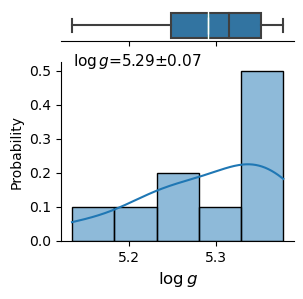

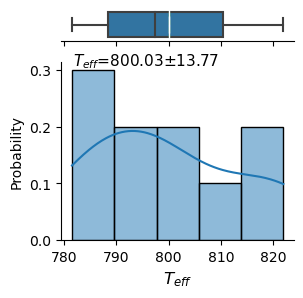

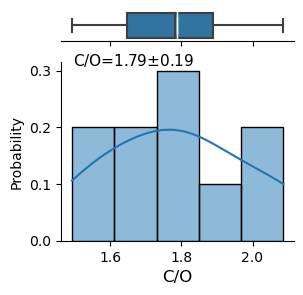

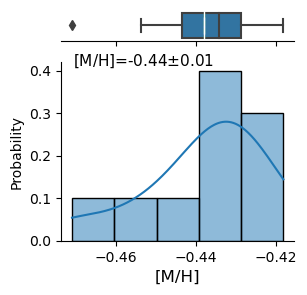

In [40]:
df_random_pred = PredictObsParametersRegression2(object_name = 'HD3651B', #Ross458C, HD3651B, GJ570D
                                                predict_from_random_spectra = True,
                                                random_spectra_num=10,
                                                print_results = False,
                                                plot_randomly_generated_spectra = True, 
                                                print_df_describe = False,
                                                plot_histogram = False, 
                                                plot_observational_spectra_errorbar = True,
                                                plot_boxplot_hist = True,
                                                plot_predicted_vs_observed_ = False

                                                            )

## Load interpolated datasets

In [114]:
df_interpolated = pd.read_csv('../../datasets/browndwarf_R100_v4_newWL_v2__interpolated_all_met_v3.csv')

In [160]:
df_interpolated.drop_duplicates(inplace=True)
df_interpolated.reset_index(drop=True, inplace=True)
df_interpolated.drop(columns='level_0', inplace=True)
df_interpolated.head()

,level_0,2.512,2.487,2.462,2.438,2.413,2.389,2.366,2.342,2.319,...,0.933,0.924,0.915,0.906,0.897,metallicity,temperature,c_o_ratio,gravity,is_augmented
0,0,2.440827e-15,1.012849e-15,3.047872e-16,3.600847e-17,4.980329e-18,5.855357e-19,2.426948e-19,6.041291e-20,3.676488e-19,...,8.634713e-21,1.262377e-16,3.696172e-17,7.021010e-18,2.795713e-19,-1.000,200.0,0.25,3.0,no
1,1,2.440827e-15,1.012849e-15,3.047872e-16,3.600847e-17,4.980329e-18,5.855357e-19,2.426948e-19,6.041291e-20,3.676488e-19,...,8.634713e-21,1.262377e-16,3.696172e-17,7.021010e-18,2.795713e-19,-0.925,200.0,0.25,3.0,no
2,2,2.440827e-15,1.012849e-15,3.047872e-16,3.600847e-17,4.980329e-18,5.855357e-19,2.426948e-19,6.041291e-20,3.676488e-19,...,8.634713e-21,1.262377e-16,3.696172e-17,7.021010e-18,2.795713e-19,-0.850,200.0,0.25,3.0,no
3,3,2.440827e-15,1.012849e-15,3.047872e-16,3.600847e-17,4.980329e-18,5.855357e-19,2.426948e-19,6.041291e-20,3.676488e-19,...,8.634713e-21,1.262377e-16,3.696172e-17,7.021010e-18,2.795713e-19,-0.775,200.0,0.25,3.0,no
4,4,2.440827e-15,1.012849e-15,3.047872e-16,3.600847e-17,4.980329e-18,5.855357e-19,2.426948e-19,6.041291e-20,3.676488e-19,...,8.634713e-21,1.262377e-16,3.696172e-17,7.021010e-18,2.795713e-19,-0.700,200.0,0.25,3.0,no


In [161]:
df_interpolated.drop(columns='level_0', inplace=True)


In [193]:
# Specify target values
targets = dict ( zip( ['gravity', 'c_o_ratio', 'metallicity', 'temperature'] , [y_pred[0][i] for i in range(4)]) )
# Print the filtered DataFrame

# Filter the DataFrame and get the result
nearest_value1, filtered_df1 = filter_dataframe(df_interpolated, targets)


4.449999999999999
1.5
-0.4
850.0


In [184]:
filtered_df1.drop(columns=['gravity', 'c_o_ratio', 'metallicity', 'temperature','is_augmented'])

,2.512,2.487,2.462,2.438,2.413,2.389,2.366,2.342,2.319,2.296,...,0.981,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897
7599,1.812908e-08,1.923758e-08,1.549586e-08,1.055625e-08,8.413583e-09,4.875432e-09,3.778226e-09,2.163476e-09,4.501096e-09,2.417747e-09,...,3.102917e-08,2.353482e-08,1.716032e-08,1.597836e-08,1.475953e-08,8.993893e-09,1.309097e-08,1.195924e-08,9.227435e-09,5.374305e-09


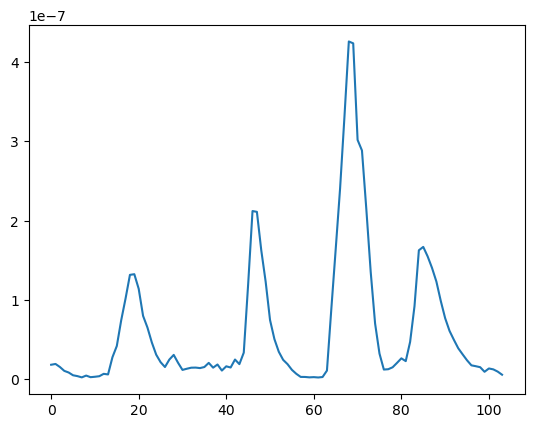

In [194]:
plt.plot(filtered_df1.drop(columns=['gravity', 'c_o_ratio', 'metallicity', 'temperature','is_augmented']).to_numpy()[0]);
# plt.plot(filtered_df2.drop(columns=['gravity', 'c_o_ratio', 'metallicity', 'temperature','is_augmented']).to_numpy()[0]);
# plt.plot(filtered_df1.iloc[:,0:-5].to_numpy()[0]);

### Load X and y StandardScaler Operators

In [218]:
object_name = 'HD3651B'

fluxcal = pd.read_csv(f'../../datasets/observational_spectra/{object_name}_fluxcal.dat', 
                   delim_whitespace=True, comment='#', names=('wl','F_lambda','F_lambda_error'), 
                   usecols=(0,1,2))#.dropna(inplace=True)

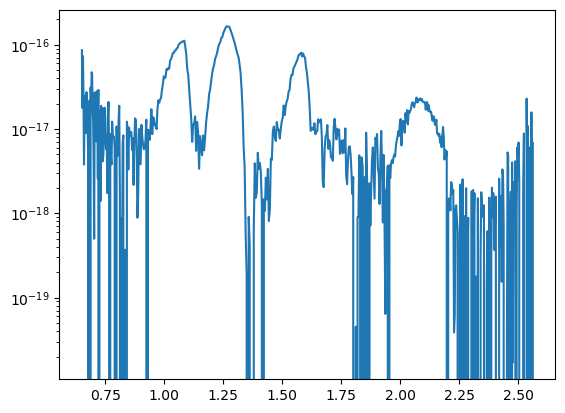

In [219]:
plt.semilogy( fluxcal['wl'],fluxcal['F_lambda'])

In [220]:
fluxcal['F_lambda']=fluxcal['F_lambda'].mask(fluxcal['F_lambda'].lt(0),0)
fluxcal['F_lambda'].replace(0, np.nan, inplace=True)
fluxcal['F_lambda'].interpolate(inplace=True)

In [221]:
bd_object = ProcessObservationalDataset( feature_values_obs = fluxcal['F_lambda'].values,
                                 feature_names_obs  = fluxcal['wl'].values, 
                                 feature_names_synthetic = wl['wl'].values,
                                )

# add the BD derived values: name, Teff, logg, met, distance_pc, radius_Rjup
if object_name == 'Ross458C':
    bd_object.bd_info('Ross458C','804','4.09','0.23', 11.509, 0.68 )
if object_name == 'HD3651B':
    bd_object.bd_info('HD3651B','818','3.94','-0.22', 11.134, 0.81 )
if object_name == 'GJ570D':
    bd_object.bd_info('GJ570D','818','3.94','-0.22', 5.884, 0.79 )    




bd_object.flux_interpolated(print_results=False, 
                            plot_results=True,
                            use_spectres=True
                           )
bd_object.df_flux_object     

# print(bd_object.df_flux_object[::-1] )

,0.897,0.906,0.915,0.924,0.933,0.943,0.952,0.962,0.971,0.981,...,2.296,2.319,2.342,2.366,2.389,2.413,2.438,2.462,2.487,2.512
0,5.997174e-09,8.576299e-09,6.022747e-09,1.077888e-08,9.085077e-09,1.302502e-08,1.262613e-08,1.206215e-08,1.860160e-08,2.463705e-08,...,7.905764e-09,6.980955e-09,6.795411e-09,4.822663e-09,7.304593e-09,1.166870e-08,8.334444e-09,1.709369e-08,1.834442e-08,2.162885e-08


### Create Min Max features


In [222]:
bd_object.df_flux_object_min = bd_object.df_flux_object.min(axis=1)
bd_object.df_flux_object_max = bd_object.df_flux_object.max(axis=1)

df_MinMax_obs = pd.DataFrame(( bd_object.df_flux_object_min, bd_object.df_flux_object_max)).T

xxx2 = train_cnn_regression.standardize_X_ColumnWise.transform(df_MinMax_obs.values)

xxx2

array([[-0.32750933, -0.43744954]])

### Create normalized X_obs 

X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))

X_scaled = X_std * (max - min) + min

In [223]:
X_std = (bd_object.df_flux_object.values[0] - bd_object.df_flux_object.min(axis=1)[0]) / (bd_object.df_flux_object.max(axis=1)[0] - bd_object.df_flux_object.min(axis=1)[0])
X_scaled = X_std * (1. - 0.) + 0.

In [224]:
X_scaled = X_scaled[::-1].reshape(1,104)

In [225]:
y_pred_train = np.array(train_cnn_regression.trained_model.predict([X_scaled,xxx2]) )[:,:,0].T
y_pred_train_ = train_cnn_regression.standardize_y_ColumnWise.inverse_transform( y_pred_train )
y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
y_pred = y_pred_train_

1/1 [==============================] - 0s 184ms/step


In [226]:
y_pred

array([[ 4.4351401e+00,  1.3626504e+00, -3.9811030e-01,  8.4583411e+02]],
      dtype=float32)

In [227]:
nearest_value1, filtered_df1 = filter_dataframe(df_interpolated, targets)
display(filtered_df1)

ValueError: too many values to unpack (expected 2)

In [228]:
import pandas as pd
import numpy as np
nearest_value_list = []

def filter_dataframe(dataset, targets):
    # Check if the values exist in the respective columns
    for col, value in targets.items():
        if value not in df[col].values:
            # Find the nearest values in the column
            nearest_value = dataset[col].values[np.argmin(np.abs(dataset[col].values - value))]
            print(nearest_value)
            targets[col] = nearest_value
            nearest_value_list.append(nearest_value)

    # Filter the DataFrame based on the values
    filtered_df = dataset
    for col, value in targets.items():
        filtered_df = filtered_df[filtered_df[col] == value]

    return nearest_value_list, filtered_df

# Specify target values
targets = dict ( zip( ['gravity', 'c_o_ratio', 'metallicity', 'temperature'] , [y_pred[0][i] for i in range(4)]) )
# Print the filtered DataFrame

# Filter the DataFrame and get the result
nearest_value1, filtered_df1 = filter_dataframe(df_interpolated, targets)
display(filtered_df1)


#### ====================================================================================================
#### ====================================================================================================
#### ====================================================================================================
#### ====================================================================================================
#### ====================================================================================================

# Create the figure
p = figure(title='GJ570D [XNorm, yStand] Predicted: '+', '.join([['logg= ','C/O= ', 'Met= ', 'T= '][i]+str(np.round(y_pred[0][i],2)) for i in  range(4)]), 
           x_axis_label='features [wavelengths]', 
           y_axis_label='Flux (Fν)',
           width=1000, height=300,
           y_axis_type = 'log')

filtered_df1 = filtered_df1.drop(columns=['gravity', 'c_o_ratio', 'metallicity', 'temperature','is_augmented']).to_numpy()[0]

# Add the scatter plot
p.line(x =wl['wl'] , y=filtered_df1, 
       line_width = 1,
       legend_label='Modeled:'+', '.join([['logg= ','C/O= ', 'Met= ', 'T= '][i]+str(np.round(nearest_value1[i],2)) for i in  range(4)]))



p.line(x =wl['wl'] , y=bd_object.df_flux_object.iloc[:, ::-1].values[0],
       line_color = 'orange', line_width = 2,
       legend_label='Observation')

p.circle(x = wl['wl'] , y=bd_object.df_flux_object.iloc[:, ::-1].values[0],
       line_width = 2,
         line_color = 'orange'
       # legend_label='Observation'
        )


# Increase size of x and y ticks
p.title.text_font_size = '12pt'
p.xaxis.major_label_text_font_size = '12pt'
p.xaxis.axis_label_text_font_size = '12pt'
p.yaxis.major_label_text_font_size = '12pt'
p.yaxis.axis_label_text_font_size = '12pt'

        
p.legend.location = "bottom_right"
p.legend.background_fill_color = 'white'
p.legend.background_fill_alpha = 0.5
        
        # Add the error bars using vbar
# p.vbar('x_err', top='upper', bottom='lower', width=0.001, source=source, line_color='grey')

# Show the plot
show(p)

4.449999999999999
1.5
-0.4
850.0


,2.512,2.487,2.462,2.438,2.413,2.389,2.366,2.342,2.319,2.296,...,0.933,0.924,0.915,0.906,0.897,metallicity,temperature,c_o_ratio,gravity,is_augmented
799345,1.803594e-08,1.902631e-08,1.519702e-08,1.031311e-08,8.240225e-09,4.760898e-09,3.684119e-09,2.106522e-09,4.365152e-09,2.347693e-09,...,9.161352e-09,1.333514e-08,1.219162e-08,9.397544e-09,5.461603e-09,-0.4,850.0,1.5,4.45,no


In [229]:
import pandas as pd
import numpy as np

def filter_dataframe(df, targets):
    # Check if the values exist in the respective columns
    for col, value in targets.items():
        if value not in df[col].values:
            # Find the nearest values in the column
            nearest_value = df[col].values[np.argmin(np.abs(df[col].values - value))]
            print(nearest_value)
            targets[col] = nearest_value

    # Filter the DataFrame based on the values
    filtered_df = df
    for col, value in targets.items():
        filtered_df = filtered_df[filtered_df[col] == value]

    return filtered_df

# Specify target values
targets = dict ( zip( ['gravity', 'c_o_ratio', 'metallicity', 'temperature'] , [y_pred[0][i] for i in range(4)]) )
# Print the filtered DataFrame

# Filter the DataFrame and get the result
filtered_df1 = filter_dataframe(df, targets)
display(filtered_df1)

targets = dict ( zip( ['gravity', 'c_o_ratio', 'metallicity', 'temperature'] , [4, 1, 0, 900]) )
filtered_df2 = filter_dataframe(df, targets)
# display(filtered_df2)


4.5
1.5
-0.3
850


,gravity,temperature,c_o_ratio,metallicity,2.512,2.487,2.462,2.438,2.413,2.389,...,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897,is_augmented
7599,4.5,850,1.5,-0.3,1.812908e-08,1.923758e-08,1.549586e-08,1.055625e-08,8.413583e-09,4.875432e-09,...,2.353482e-08,1.716032e-08,1.597836e-08,1.475953e-08,8.993893e-09,1.309097e-08,1.195924e-08,9.227435e-09,5.374305e-09,no


In [142]:
fluxcal

,wl,F_lambda,F_lambda_error
0,0.650857,8.606238e-17,4.358173e-17
1,0.653073,1.771977e-17,3.360256e-17
2,0.655278,7.300979e-17,3.132892e-17
3,0.657472,2.569511e-17,2.837585e-17
4,0.659659,3.786160e-18,2.497690e-17
...,...,...,...
559,2.550960,6.071953e-18,3.190524e-17
560,2.553900,1.090368e-17,3.022278e-17
561,2.556850,1.573540e-17,2.389914e-17
562,2.559820,1.129194e-17,1.702191e-17


In [143]:
np.random.normal(1 , .2 )

1.0842212908366382

In [144]:
fluxcal['F_lambda'][10], fluxcal['F_lambda_error'][10]

(1.7343874908375014e-17, 2.5124289499773257e-17)

In [145]:
list_ = []
for _ in range(10):
    list_.append ( np.random.normal(fluxcal['F_lambda'] , fluxcal['F_lambda_error'] ) )

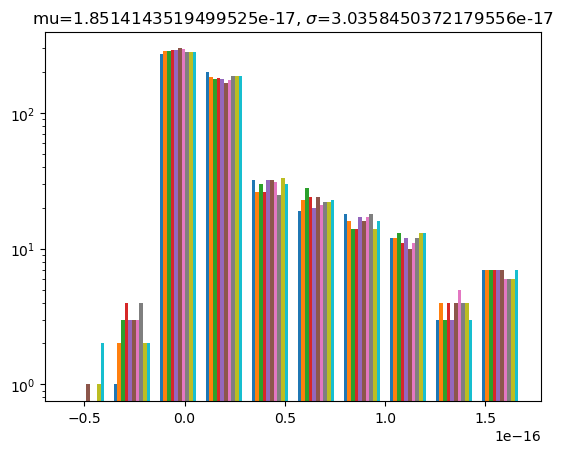

In [146]:
plt.hist( list_ , log = True)
plt.title(f'mu={np.mean(list_)}, $\sigma$={np.std(list_)}');

In [147]:
list_ = []
for _ in range(1000):
    list_.append ( fluxcal['F_lambda_error'] - [ np.random.normal(mu , sigma ) 
                                                    for mu, sigma in zip(fluxcal['F_lambda'], fluxcal['F_lambda_error']) ] ) 

In [148]:
np.mean(list_)

-1.4757899430091664e-17

In [149]:
fluxcal['F_lambda_error'] * np.random.randn(fluxcal['F_lambda']) + mu

TypeError: 'Series' object cannot be interpreted as an integer

In [ ]:
[f + np.random.randn(stdev, mean) for f, sig1 in zip(, fluxcal['F_lambda_error'])]

In [ ]:
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource
from bokeh.io import output_notebook

def plot_spectra_errorbar(object_name, x, y, error):
    # # Sample data
    # x = fluxcal['wl']
    # y = fluxcal['F_lambda']
    # error = fluxcal['F_lambda_error']

    # Calculate the error bar coordinates
    x_err = x
    y_err = y
    upper = [y_val + err_val for y_val, err_val in zip(y, error)]
    lower = [y_val - err_val for y_val, err_val in zip(y, error)]

    # Create a ColumnDataSource to store the data
    source = ColumnDataSource(data=dict(x=x, y=y, x_err=x_err, y_err=y_err, upper=upper, lower=lower))

    # Create the figure
    p = figure(title=object_name+': Calibrated Observational Spectra', 
               x_axis_label='features [wavelengths]', 
               y_axis_label='Flux (Fν)',
               width=1000, height=300,
               y_axis_type='log')

    # Set the font size for axis labels and tick labels
    p.xaxis.axis_label_text_font_size = '14pt'
    p.yaxis.axis_label_text_font_size = '14pt'
    p.xaxis.major_label_text_font_size = '12pt'
    p.yaxis.major_label_text_font_size = '12pt'

    # Add the scatter plot
    p.scatter('x', 'y', source=source, legend_label='Data')

    # Add the error bars using vbar
    p.vbar('x_err', top='upper', bottom='lower', width=0.001, source=source, line_color='gray', line_alpha = 0.4)

    # Show the plot
    output_notebook()
    show(p)


In [150]:
filtered_df1.iloc[:,4:-1]

,2.512,2.487,2.462,2.438,2.413,2.389,2.366,2.342,2.319,2.296,...,0.981,0.971,0.962,0.952,0.943,0.933,0.924,0.915,0.906,0.897
7599,1.812908e-08,1.923758e-08,1.549586e-08,1.055625e-08,8.413583e-09,4.875432e-09,3.778226e-09,2.163476e-09,4.501096e-09,2.417747e-09,...,3.102917e-08,2.353482e-08,1.716032e-08,1.597836e-08,1.475953e-08,8.993893e-09,1.309097e-08,1.195924e-08,9.227435e-09,5.374305e-09


In [151]:
import seaborn as sns
def boxplot_hist(data, x_label, xy_loc):
    
    fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
    
    sns.histplot(data, ax=ax_hist, kde=True, stat='probability')
    sns.boxplot(x = data, ax=ax_box, showmeans=True, meanline = True,
                meanprops={"marker": "|",
                           "markeredgecolor": "white",
                           "markersize": "30", 
                            }
                       )
    
    fig.set_figheight(3)
    fig.set_figwidth(3)

    ax_box.set(xlabel='')
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    ax_box.set_yticks([])

    mean = np.round(np.mean(data),2)
    std = np.round(np.std(data),2)
    plt.annotate(f'{x_label}='+str(np.round(mean,2))+'$\pm$'+str(np.round(std,2)), fontsize=11, 
                 xy=(xy_loc[0], xy_loc[1]), xycoords='axes fraction')
                    
    plt.xlabel(x_label, fontsize = 12)

    plt.show()

In [152]:
import random
from bokeh.palettes import Magma, Inferno, Plasma, Viridis, Cividis
from bokeh.palettes import  viridis, inferno
       

    
def PredictObsParametersRegression2(object_name, 
                                    predict_from_random_spectra = True,
                                    random_spectra_num=10,
                                    print_results = False,
                                    plot_randomly_generated_spectra = False,
                                    print_df_describe = False,
                                    plot_histogram = False,
                                    plot_observational_spectra_errorbar = True,
                                    plot_boxplot_hist = True
                                   ):


    spectra_list = []
    param_list = []    
    color = viridis(101).__iter__()


    fluxcal = pd.read_csv(f'../../datasets/observational_spectra/{object_name}_fluxcal.dat', 
                       delim_whitespace=True, comment='#', names=('wl','F_lambda','F_lambda_error'), 
                       usecols=(0,1,2))#.dropna(inplace=True)

    fluxcal['F_lambda']=fluxcal['F_lambda'].mask(fluxcal['F_lambda'].lt(0),0)
    fluxcal['F_lambda'].replace(0, np.nan, inplace=True)
    fluxcal['F_lambda'].interpolate(inplace=True)

    bd_object = ProcessObservationalDataset( feature_values_obs = fluxcal['F_lambda'].values,
                                     feature_names_obs  = fluxcal['wl'].values, 
                                     feature_names_synthetic = wl['wl'].values,
                                    )
    
    if plot_observational_spectra_errorbar:
        plot_spectra_errorbar(object_name, 
                              x = fluxcal['wl'], 
                              y = fluxcal['F_lambda'],
                              error = fluxcal['F_lambda_error'])
    

    # add the BD derived values: name, Teff, logg, met, distance_pc, radius_Rjup
    if object_name == 'Ross458C':
        bd_object.bd_info('Ross458C','804','4.09','0.23', 11.509, 0.68 )
    if object_name == 'HD3651B':
        bd_object.bd_info('HD3651B','818','3.94','-0.22', 11.134, 0.81 )
    if object_name == 'GJ570D':
        bd_object.bd_info('GJ570D','818','3.94','-0.22', 5.884, 0.79 )    




    bd_object.flux_interpolated(print_results=False, 
                                plot_results=True,
                                use_spectres=True
                               )
    bd_object.df_flux_object     


    
    # ********************************* 
    bd_object.df_flux_object_min = bd_object.df_flux_object.min(axis=1)
    bd_object.df_flux_object_max = bd_object.df_flux_object.max(axis=1)

    df_MinMax_obs = pd.DataFrame(( bd_object.df_flux_object_min, bd_object.df_flux_object_max)).T

    xxx2 = train_cnn_regression.standardize_X_ColumnWise.transform(df_MinMax_obs.values)


    X_std = (bd_object.df_flux_object.values[0] - bd_object.df_flux_object.min(axis=1)[0]) / (bd_object.df_flux_object.max(axis=1)[0] - bd_object.df_flux_object.min(axis=1)[0])
    X_scaled = X_std * (1. - 0.) + 0.
    #     bd_mean = bd_object.df_flux_object.mean(axis=1)[0]  
    #     bd_std = bd_object.df_flux_object.std(axis=1)[0]     

    #     X_scaled = (bd_object.df_flux_object.values[0] - bd_mean) / bd_std

    y_pred_train = np.array(train_cnn_regression.trained_model.predict([X_scaled[::-1].reshape(1,104),xxx2], verbose=0))[:,:,0].T
    y_pred_train_ = train_cnn_regression.standardize_y_ColumnWise.inverse_transform( y_pred_train )
    y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
    y_pred = y_pred_train_
    # ********************************* 
            
    #     xxx = train_cnn_regression.standardize_X_ColumnWise.transform( bd_object.df_flux_object.iloc[:, ::-1] )

    #     y_pred_train = np.array(train_cnn_regression.trained_model.predict(xxx) )[:,:,0].T
    #     y_pred_train_ = train_cnn_regression.standardize_y_ColumnWise.inverse_transform( y_pred_train )
    #     y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
    #     y_pred = y_pred_train_       
        
        
        
    if predict_from_random_spectra:
        for i in range(random_spectra_num):
            # Comment from Natasha: 
            spectra = pd.DataFrame( np.random.normal(fluxcal['F_lambda'] , fluxcal['F_lambda_error'] ) ,
                                     columns=['F_lambda'])
            # spectra = pd.DataFrame( [random.uniform(fluxcal.F_lambda[i]-1*fluxcal.F_lambda_error[i], 
                                 # fluxcal.F_lambda[i]+1*fluxcal.F_lambda_error[i]) 
                                 # for i in range(len(fluxcal))],columns=['F_lambda'] )
            
            
#scipy guass



            # Process the dataset
            spectra['F_lambda'] = spectra['F_lambda'].mask(spectra['F_lambda'].lt(0),0)
            spectra['F_lambda'].replace(0, np.nan, inplace=True)
            spectra['F_lambda'].interpolate(inplace=True)


            # Instintiate Process Observational Dataset class
            bd_object_generated = ProcessObservationalDataset( feature_values_obs = spectra['F_lambda'].values,
                                             feature_names_obs  = fluxcal['wl'].values, 
                                             feature_names_synthetic = wl['wl'].values,
                                            )


            # add the BD derived values: name, Teff, logg, met, distance_pc, radius_Rjup
            if object_name == 'Ross458C':
                bd_object_generated.bd_info('Ross458C','804','4.09','0.23', 11.509, 0.68 )
            if object_name == 'HD3651B':
                bd_object_generated.bd_info('HD3651B','818','3.94','-0.22', 11.134, 0.81 )
            if object_name == 'GJ570D':
                bd_object_generated.bd_info('GJ570D','818','3.94','-0.22', 5.884, 0.79 )    
    



            bd_object_generated.flux_interpolated(print_results=False, 
                                        plot_results=False,
                                        use_spectres=True
                                       )
            bd_object_generated.df_flux_object    
    
            # bd_object_generated.flux_interpolated(print_results=False, plot_results=False)
            # bd_object_generated.df_flux_object.values
            spectra_list.append(bd_object_generated.df_flux_object.values)
            
            # ********************************* 
            bd_object_generated.df_flux_object_min = bd_object_generated.df_flux_object.min(axis=1)
            bd_object_generated.df_flux_object_max = bd_object_generated.df_flux_object.max(axis=1)

            df_MinMax_obs = pd.DataFrame(( bd_object_generated.df_flux_object_min, bd_object_generated.df_flux_object_max)).T

            xxx2 = train_cnn_regression.standardize_X_ColumnWise.transform(df_MinMax_obs.values)

            
            X_std = (bd_object_generated.df_flux_object.values[0] - bd_object_generated.df_flux_object.min(axis=1)[0]) / (bd_object_generated.df_flux_object.max(axis=1)[0] - bd_object.df_flux_object.min(axis=1)[0])
            X_scaled = X_std * (1. - 0.) + 0.

            # bd_mean = bd_object_generated.df_flux_object.mean(axis=1)[0]  
            # bd_std = bd_object_generated.df_flux_object.std(axis=1)[0]     

            # X_scaled = (bd_object_generated.df_flux_object.values[0] - bd_mean) / bd_std

            y_pred_train = np.array(train_cnn_regression.trained_model.predict([X_scaled[::-1].reshape(1,104),xxx2], verbose=0) )[:,:,0].T
            y_pred_train_ = train_cnn_regression.standardize_y_ColumnWise.inverse_transform( y_pred_train )
            y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
            y_pred = y_pred_train_
            # ********************************* 


#             xxx = train_cnn_regression.standardize_X_ColumnWise.transform( bd_object_generated.df_flux_object.iloc[:, ::-1] )

#             y_pred_train = np.array(train_cnn_regression.trained_model.predict(xxx) )[:,:,0].T
#             y_pred_train_ = train_cnn_regression.standardize_y_ColumnWise.inverse_transform( y_pred_train )
#             y_pred_train_ [:,3] = 10**y_pred_train_[:,3]
#             y_pred = y_pred_train_    
            
            # print(y_pred)
    
    
            param_list.append(  y_pred[0] )

        df_random_pred = pd.DataFrame(param_list, columns=['logg' ,'c_o' ,'met' ,'T'] )
        display(df_random_pred.describe())
            
        if print_results:
            print(param_list)

        if plot_randomly_generated_spectra:
            p = figure(title=object_name+": Randomly generated spectra within 1σ", 
                       x_axis_label='features [wavelengths]', y_axis_label='Flux (Fν)',
                       width=1000, height=300,
                       y_axis_type="log", background_fill_color="#fafafa"
                      )
            

            for i in range(0,random_spectra_num,int(random_spectra_num/5)):
                    p.line(wl.wl.values[::-1],spectra_list[i][0], 
                           line_width = 1,
                           line_alpha = 0.6, 
                           line_color=next(color),
                           )

                    
                    
        # Set the font size for axis labels and tick labels
        p.xaxis.axis_label_text_font_size = '14pt'
        p.yaxis.axis_label_text_font_size = '14pt'
        p.xaxis.major_label_text_font_size = '12pt'
        p.yaxis.major_label_text_font_size = '12pt'
        show(p)

            
        if print_df_describe:
            display(df_random_pred.describe())
            
            
        if plot_histogram:
            plt.figure()
            df_random_pred.hist()
            plt.show()
        
        if plot_boxplot_hist: 
            boxplot_hist(df_random_pred['logg'],  x_label=r'$\log g$', xy_loc=[0.05,0.98],)
            boxplot_hist(df_random_pred['T'],x_label=r'$T_{eff}$', xy_loc=[0.05,0.98],)
            boxplot_hist(df_random_pred['c_o'], x_label=r'C/O', xy_loc=[0.05,0.98],)
            boxplot_hist(df_random_pred['met'], x_label=r'[M/H]', xy_loc=[0.05,0.98],)
            

    return df_random_pred

        

            
            

Loading BokehJS ...

,logg,c_o,met,T
count,100.000000,100.000000,100.000000,100.000000
mean,4.866055,1.540778,-0.297709,905.659912
std,0.164308,0.188198,0.133676,34.158211
min,4.537449,1.103969,-0.482445,836.316040
25%,4.765409,1.419325,-0.394640,883.439926
50%,4.864303,1.561086,-0.352819,900.489929
75%,4.992751,1.678217,-0.253267,924.080612
max,5.267609,1.917366,0.192609,1011.106140


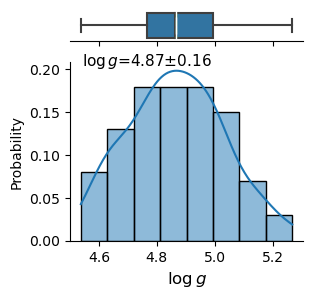

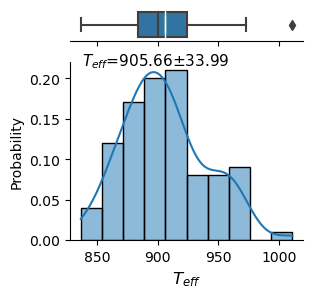

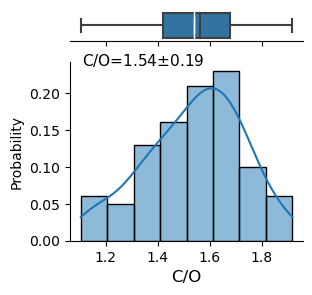

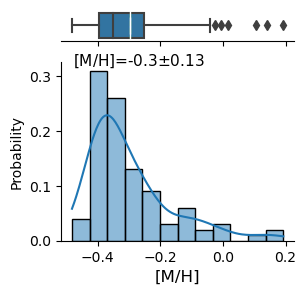

In [153]:
df_random_pred = PredictObsParametersRegression2(object_name = 'GJ570D', #Ross458C, HD3651B, GJ570D
                                                predict_from_random_spectra = True,
                                                random_spectra_num=100,
                                                print_results = False,
                                                plot_randomly_generated_spectra = True, 
                                                print_df_describe = False,
                                                plot_histogram = False, 
                                                plot_observational_spectra_errorbar = True,
                                                plot_boxplot_hist = True

                                                            )

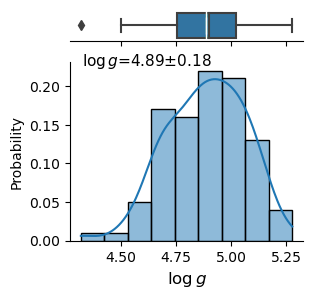

In [83]:
boxplot_hist(df_random_pred['logg'],  x_label=r'$\log g$', xy_loc=[0.05,0.98],)

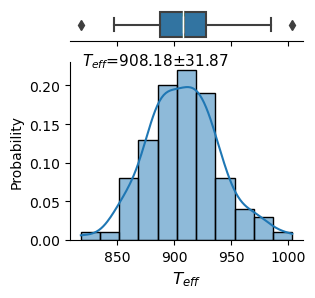

In [84]:
boxplot_hist(df_random_pred['T'],x_label=r'$T_{eff}$', xy_loc=[0.05,0.98],)

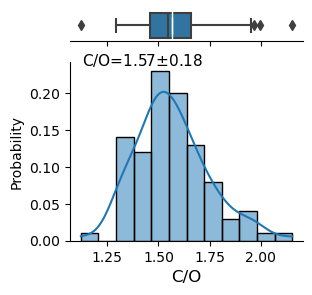

In [121]:
boxplot_hist(df_random_pred['c_o'], x_label=r'C/O', xy_loc=[0.05,0.98],)

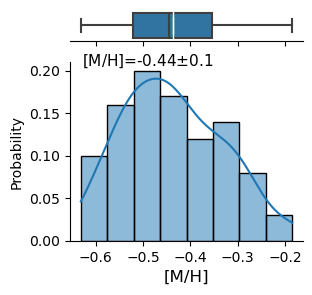

In [122]:
boxplot_hist(df_random_pred['met'], x_label=r'[M/H]', xy_loc=[0.05,0.98],)

---

## HD3651B

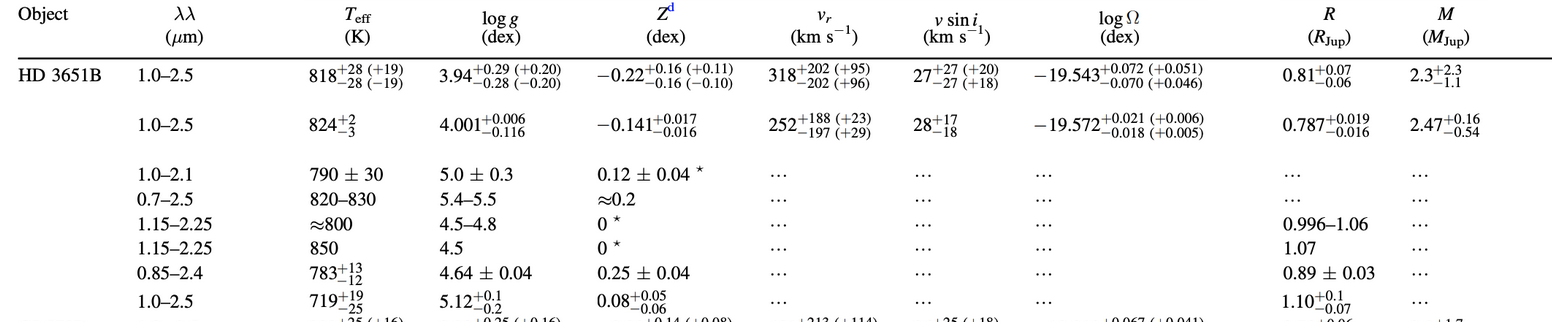

In [130]:
# plt.semilogy( df[df['temperature']==800].drop(columns=['gravity','temperature','c_o_ratio','metallicity','is_augmented']));

In [529]:
df_random_pred = PredictObsParametersRegression2(object_name = 'HD3651B', 
                                                predict_from_random_spectra = True,
                                                random_spectra_num=100,
                                                print_results = False,
                                                plot_results = True,
                                                print_df_describe = False,
                                                plot_histogram = False, 
                                                            )

1/1 [==============================] - 0s 125ms/step


,logg,c_o,met,T
count,100.000000,100.000000,100.000000,100.000000
mean,4.857421,1.410336,-0.713726,808.738342
std,0.064556,0.055257,0.048653,7.695847
min,4.695873,1.248216,-0.824881,791.412537
25%,4.812944,1.378087,-0.749184,803.610107
50%,4.861358,1.420396,-0.713367,808.425018
75%,4.904747,1.447242,-0.673975,814.355209
max,5.022175,1.549816,-0.614226,829.947632


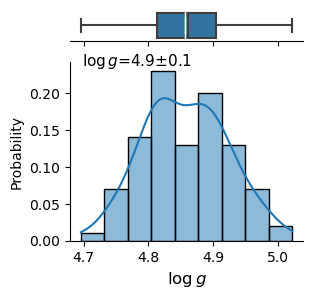

In [530]:
boxplot_hist(df_random_pred['logg'],  x_label=r'$\log g$', xy_loc=[0.05,0.98],)

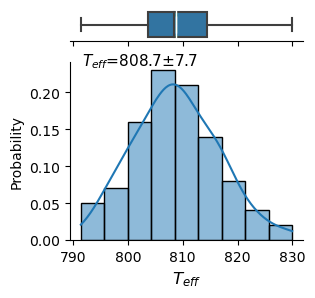

In [531]:
boxplot_hist(df_random_pred['T'],x_label=r'$T_{eff}$', xy_loc=[0.05,0.98],)

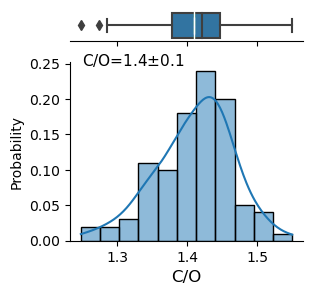

In [532]:
boxplot_hist(df_random_pred['c_o'], x_label=r'C/O', xy_loc=[0.05,0.98],)

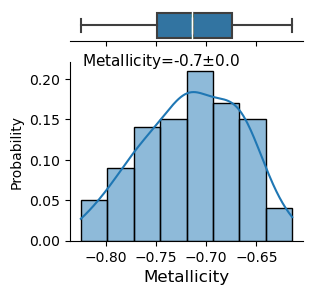

In [533]:
boxplot_hist(df_random_pred['met'], x_label=r'Metallicity', xy_loc=[0.05,0.98],)

---

# Step 5: tensorflow_probability

In [114]:
import tensorflow_probability as tfp

def function_factory(model, loss, train_x, train_y, test_x, test_y):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).
        train_x [in]: the input part of training data.
        train_y [in]: the output part of training data.
        ## DP addition:
        test_x [in]: the input part of test data (just for metric purposes)
        test_y [in]: the output part of test data (just for metric purposes)
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later, so we need to
    # prepare required information first
    count = 0
    idx = [] # stitch indices
    part = [] # partition indices

    for i, shape in enumerate(shapes):
        n = np.product(shape)
        idx.append(tf.reshape(tf.range(count, count+n, dtype=tf.int32), shape))
        part.extend([i]*n)
        count += n

    part = tf.constant(part)

    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """

        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(tf.reshape(param, shape))

    # now create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as tape:
            # update the parameters in the model
            assign_new_model_parameters(params_1d)
            # calculate the loss
            loss_value = loss(model(train_x, training=True), train_y)
            

        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_value, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)

        # print out iteration & loss
        f.iter.assign_add(1)
        test_loss=loss(model(test_x), test_y)
        tf.print("Iter:", f.iter, "loss:", loss_value, "test loss:", test_loss)

        # store loss and test_loss values so we can retrieve later
        tf.py_function(f.history.append, inp=[[loss_value, test_loss]], Tout=[])

        return loss_value, grads

    # store these information as members so we can use them outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f

In [ ]:
cnn_model

In [115]:
##### TRAIN MODEL WITH L-BFGS optimizer ##########

## Define the type of loss function we want to use
loss_fun = tf.keras.losses.Huber()

## Create a function that agregates our cnn model, etc to pass it to the optimizer
func = function_factory(cnn_model.trained_model, loss_fun, 
                            [cnn_model.X_train.astype(np.float32), cnn_model.X2_train.astype(np.float32)], cnn_model.y_train.astype(np.float32),
                            [cnn_model.X_test.astype(np.float32), cnn_model.X2_test.astype(np.float32)],
                            cnn_model.y_test.astype(np.float32),)
                        # x_train_scaled_rowcol, y_train, x_test_scaled_rowcol, y_test)

## Convert initial model parameters to a 1D tf.Tensor
init_params = tf.dynamic_stitch(func.idx, cnn_model.trained_model.trainable_variables)

## Train the model with L-BFGS solver
results = tfp.optimizer.lbfgs_minimize(value_and_gradients_function=func, \
                                       initial_position=init_params, max_iterations=100)

## After training, the final optimized parameters are still in results.position
## so we have to manually put them back to the model
func.assign_new_model_parameters(results.position)

NameError: name 'cnn_model' is not defined

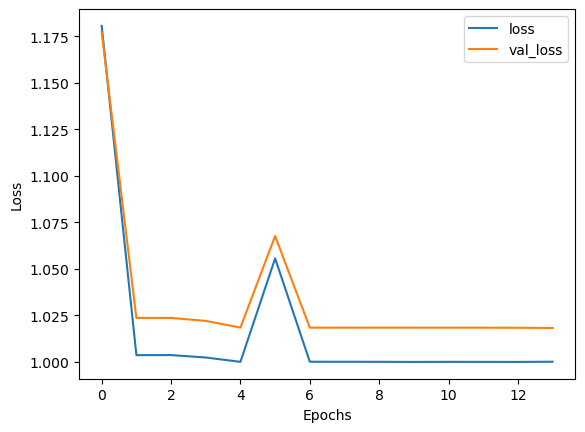

In [26]:
## If you used Livelossplot, you can skip this. Otherwise we can take a look at the training process by plotting the
## models history.
plt.plot(np.array( func.history )[2:,0], label='loss')
plt.plot(np.array( func.history )[2:,1], label='val_loss')
plt.yscale('linear')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
## In case you used ReduceLROnPlateau() you can plot the lr as well
# ax2 = plt.gca().twinx()
# ax2.plot(h1.history['lr'], color='r')
# ax2.set_ylabel('lr',color='r')
# plt.ylim((1e-2,0.1))
plt.show()

In [49]:
cnn_model.trained_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 104, 1)]     0           []                               
                                                                                                  
 input1-Scaled (Conv1D)         (None, 35, 5)        50          ['input_3[0][0]']                
                                                                                                  
 Conv1D_layer1 (Conv1D)         (None, 35, 68)       19108       ['input1-Scaled[0][0]']          
                                                                                                  
 MaxPooling1D_layer1 (MaxPoolin  (None, 7, 68)       0           ['Conv1D_layer1[0][0]']          
 g1D)                                                                                       

In [63]:
# cnn_model.trained_model.trainable_variables

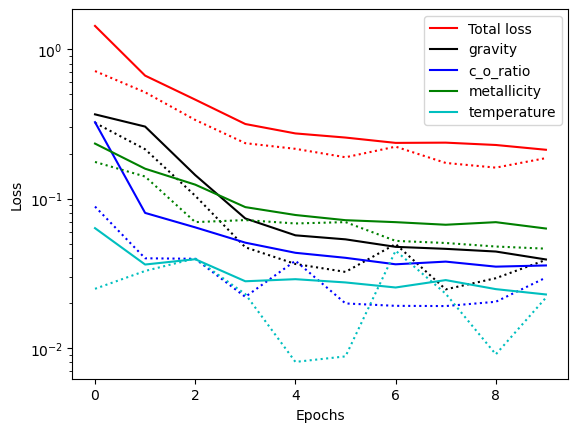

In [27]:
## If you used Livelossplot, you can skip this. Otherwise we can take a look at the training process by plotting the
## models history.
plt.plot(trained_cnn_model['history'].history['loss'], 'r-',label='Total loss')
plt.plot(trained_cnn_model['history'].history['val_loss'], 'r:')

plt.plot(trained_cnn_model['history'].history['gravity_loss'], 'k-',label='gravity')
plt.plot(trained_cnn_model['history'].history['val_gravity_loss'], 'k:')

plt.plot(trained_cnn_model['history'].history['c_o_ratio_loss'], 'b-',label='c_o_ratio')
plt.plot(trained_cnn_model['history'].history['val_c_o_ratio_loss'], 'b:')


plt.plot(trained_cnn_model['history'].history['metallicity_loss'], 'g-',label='metallicity')
plt.plot(trained_cnn_model['history'].history['val_metallicity_loss'], 'g:')

plt.plot(trained_cnn_model['history'].history['temperature_loss'], 'c-',label='temperature')
plt.plot(trained_cnn_model['history'].history['val_temperature_loss'], 'c:', )


plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
## In case you used ReduceLROnPlateau() you can plot the lr as well
# ax2 = plt.gca().twinx()
# ax2.plot(h1.history['lr'], color='r')
# ax2.set_ylabel('lr',color='r')
plt.show();